In [1]:
import base64
import requests

import subprocess
from getpass import getpass

password = getpass()
cmd = ["openssl", "enc", "-d", "-aes-256-cbc", "-in", "openai-key.enc", "-pass", f"pass:{password}"]
api_key = subprocess.run(cmd, capture_output=True, text=True).stdout.strip("\n")

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

 ········


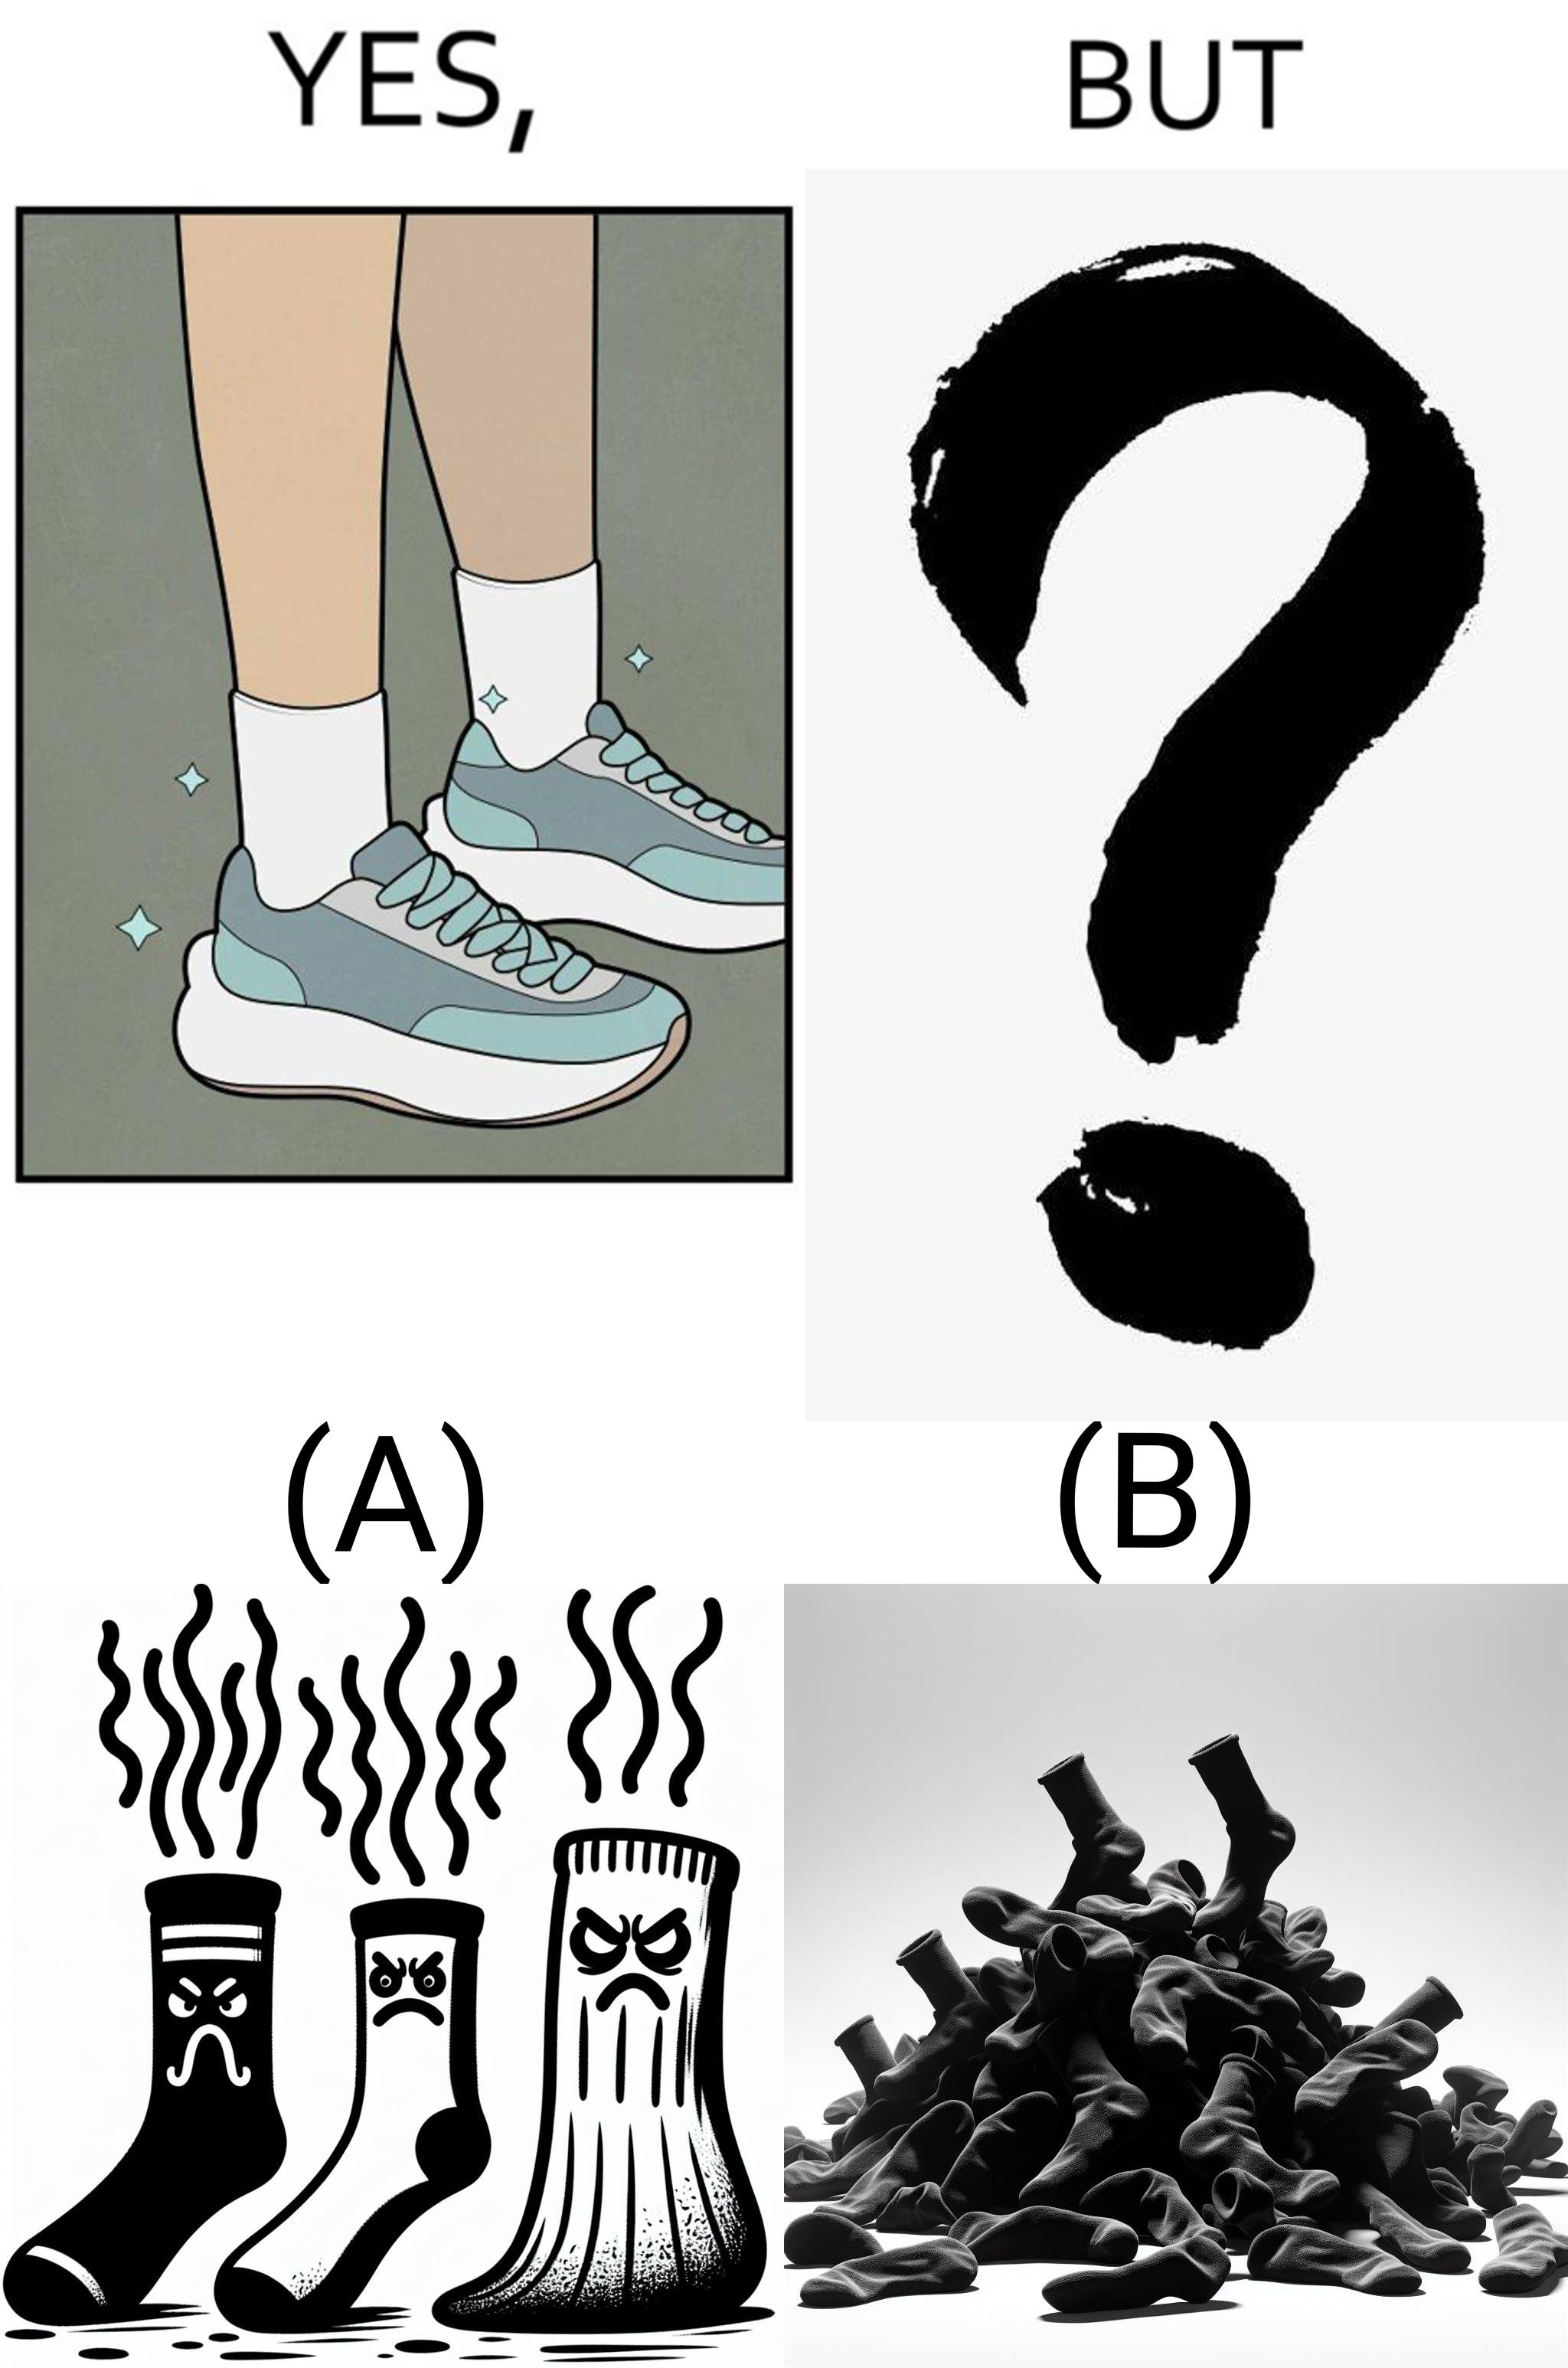

{'id': 'chatcmpl-8qmlRmEtEeTHdHzuEaIirX2aTW5ib', 'object': 'chat.completion', 'created': 1707591197, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 273, 'completion_tokens': 114, 'total_tokens': 387}, 'choices': [{'message': {'role': 'assistant', 'content': "If question mark is replaced by option A, the image will not be funny because the clean and stylish sneakers in the first image don't correlate with the sad expression of smelly socks in option A, which doesn't create a meaningful contrast or satirical context.\nIf question mark is replaced by option B, the image will be funny because it contrasts the pristine appearance of the sneakers with a mountain of singular lost socks, humorously addressing the common mystery of where the other sock vanishes to in the laundry.\nHence option B is more funny and the answer is B."}, 'finish_reason': 'stop', 'index': 0}]}


({'prompt_tokens': 273, 'completion_tokens': 114, 'total_tokens': 387},
 "If question mark is replaced by option A, the image will not be funny because the clean and stylish sneakers in the first image don't correlate with the sad expression of smelly socks in option A, which doesn't create a meaningful contrast or satirical context.\nIf question mark is replaced by option B, the image will be funny because it contrasts the pristine appearance of the sneakers with a mountain of singular lost socks, humorously addressing the common mystery of where the other sock vanishes to in the laundry.\nHence option B is more funny and the answer is B.")

In [30]:
'''You are an AI expert in detecting humour or satire. You detect and describe satire in user's image input and then classify it as either funny (Yes) or not funny (No)
                        ###Output: exactly "This image <brief one sentence description of image>. Hence the label is <label>.", where label is either "Yes" or "No"'''

def generate(prompt, image_path, verbose = False):
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode('utf-8')
    payload = {
      "model": "gpt-4-vision-preview",
      "messages": [
        {
            "role": "system",
            "content": [{"type": "text", "text": 
                         '''You are an AI expert in creating humour or satire. User gives you an image, and you have to make a choice "A" or "B".
                         ###Input: Given the image in the first row, where one sub-image is given, choose the other sub-image (shown by a question mark) from the two options A/B from the bottom row of images in such a way that the image in the first row is meaningful and satirical.
                        ###Output: exactly "If question mark is replaced by option A, the image <will/will not> be funny because <one sentence>.
                        If question mark is replace by option A, the image <will/will not> be funny because <one sentence>.
                        Hence option <answer> is more funny and the answer is <answer>." where <answer> must be either "A" or "B"'''}]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}",
                  "detail": "low"
              }
            }
          ]
        }
      ],
      "max_tokens": 128,
    }
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload).json()
    if verbose:
        from PIL import Image
        image = Image.open(image_path)
        display(image)
        print(response)
    if "usage" not in response and "error" in response:
        raise Exception(response["error"]["message"])
    return response["usage"], response["choices"][0]["message"]["content"]

generate("", "yesbut_image_completion/20240101_173219_LEFT_QMARK.jpg", True)


In [10]:
import os
def to_dalle_path(type, og_filename, side):
    return os.path.join(f"outputs/dalle3/{type.lower()}/{side.lower()}",f"{og_filename}_{type}_{side}.jpg")

def get_lr_path_from_filename(filename):
    if not "YES" in filename and not "BUT" in filename:
        yes = os.path.join("images_split",f"{filename[:-4]}_YES.jpg")
        but = os.path.join("images_split",f"{filename[:-4]}_BUT.jpg")
    else:
        parts = filename.split("_")
        #print(parts)
        og_filename = "_".join(parts[:-4])
        yestype, buttype = parts[-4], parts[-2]
        yes = to_dalle_path(yestype, og_filename, "YES") if yestype!="ORIG" else os.path.join("images_split",f"{og_filename}_YES.jpg")
        but = to_dalle_path(buttype, og_filename, "BUT") if buttype!="ORIG" else os.path.join("images_split",f"{og_filename}_BUT.jpg")
    return yes,but

print(get_lr_path_from_filename("20240101_172315_STICK_YES_3D_BUT.jpg"))

('outputs/dalle3/stick/yes/20240101_172315_STICK_YES.jpg', 'outputs/dalle3/3d/but/20240101_172315_3D_BUT.jpg')


In [32]:
import os, json
from tqdm import tqdm
from validate import validate_file

## schema [{"image_path": <>, "prompt": <>, "usage": {"prompt_tokens": ...}}]
with open("gpt4-usages.json", "r") as f:
    usages = json.load(f)
    total_usage = sum(x["usage"]["total_tokens"] for x in usages)

outpath = "outputs/completion/gpt4-vision-cot-full.json"
inpath = "yesbut_image_completion"
try:
    with open(outpath, "r") as f:
        outputs = json.load(f)
except FileNotFoundError:
    print("starting from zero")
    outputs = {}

current_usage = 0
#files = [x for x in os.listdir("images_split") if "BUT" in x]
#redo_files = [path for path,output in outputs.items() if "Rate limit reach" in output]
#print(f"Redoing {len(redo_files)} files")
files = os.listdir(inpath)
redo_files = []
# fullfiles = os.listdir(inpath)
# files = set()
# for filename in fullfiles:
#     _,but = get_lr_path_from_filename(filename)
#     if "outputs/dalle3" in but:
#         files.add(but)

with open("completion_groundtruth.json", "r") as f:
    gt = json.load(f)
total = 0
correct = 0

pbar = tqdm(files)
for filename in pbar:
#for filepath in pbar:
#    filename = filepath.split("/")[-1]
#    inpath = "/".join(filepath.split("/")[:-1])
    if filename in outputs and outputs[filename]:
        total+=1
        correct+= 1 if outputs[filename][-2]==gt[filename] else 0
        pbar.set_postfix({"current_usage": current_usage, "total_usage": total_usage, "accuracy": correct/total})
        continue
    prompt = ""
    try:
        usage, output = generate(prompt, os.path.join(inpath, filename))
    except Exception as e:
        print("Caught exception: ", str(e))
        print("Could not do: ",filename)
        usage = {'prompt_tokens': 0, 'completion_tokens': 0, 'total_tokens': 0}
        output = ""

    outputs[filename] = output
    with open(outpath, "w") as f:
        json.dump(outputs, f, indent=4)

    usages.append({"image_path":filename, "prompt": prompt, "usage": usage})
    with open("gpt4-usages.json", "w") as f:
        json.dump(usages, f, indent=2)
    
    current_usage+=usage["total_tokens"]
    total_usage+=usage["total_tokens"]
    pbar.set_postfix({"current_usage": current_usage, "total_usage": total_usage})

    total+=1
    correct+= 1 if outputs[filename] and outputs[filename][-2]==gt[filename] else 0
    pbar.set_postfix({"current_usage": current_usage, "total_usage": total_usage, "accuracy": correct/total})

with open(outpath, "w") as f:
    json.dump(outputs, f, indent=4)
# if not validate_file(outpath):
#     print("Validation failed!")    

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:46<00:00,  3.20it/s, current_usage=1830, total_usage=794304, accuracy=0.573]


In [ ]:
# whyfunny: 53930
# punchline: 63560
# left: ~60000
# right: ~60000